In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.stats import gaussian_kde
from matplotlib.ticker import MaxNLocator

In [2]:
doubles = {}
doubles_add = {}
epi_no_transf = {}
epi = {}

In [3]:
def regular_bin(x, y, nbins=10, method="mean", error="sem"):
    """
    Bins data using regular (linearly spaced) bins.

    Args:
        x (array-like): Independent variable.
        y (array-like): Dependent variable to be binned.
        nbins (int): Number of linearly spaced bins.
        method (str): Aggregation method ('mean', 'median', 'sum').
        error (str): 'std' for standard deviation or 'sem' for standard error of the mean.

    Returns:
        bin_centers (numpy array): Centers of the bins.
        y_binned (numpy array): Aggregated y-values.
        y_err (numpy array): Error bars (std or sem).
    """
    bins = np.linspace(min(x), max(x), nbins + 1)
    bin_indices = np.digitize(x, bins) - 1
    bin_centers = (bins[:-1] + bins[1:]) / 2
    y_binned = np.full(nbins, np.nan)
    y_err = np.full(nbins, np.nan)

    for i in range(nbins):
        mask = bin_indices == i
        if np.any(mask):
            y_vals = y[mask]
            if method == "mean":
                y_binned[i] = np.mean(y_vals)
            elif method == "median":
                y_binned[i] = np.median(y_vals)
            elif method == "sum":
                y_binned[i] = np.sum(y_vals)
            if error == "std":
                y_err[i] = np.std(y_vals)
            elif error == "sem":
                y_err[i] = np.std(y_vals) / np.sqrt(len(y_vals))
    return bin_centers, y_binned, y_err


In [4]:
# Compute averaged parameters for two groups
avg_params = {
    "1st": (1, 0.5492, 7.2232),
    "2nd": (1, 0.4354, 8.7439)
}
# Define logistic function
def transf(x, a, b, c):
    return -a * np.log(1 + np.exp(-b * (x + c)))


In [5]:
df = pd.read_csv('Working_Data/650/80_llm_yap1_esm2_650.csv')

In [6]:
e1 = df['Mut1_expt_fitness']
e2 = df['Mut2_expt_fitness']
e12 = df['log_fitness']
ee = e12-e1-e2 
m1 = df['mut1']
m2 = df['mut2']
m12 = df['mut12']
m21 = df['mut21']

# Apply nonlinear function with '1st' parameters to mut1 and mut2
m1t = transf(m1, *avg_params["1st"])
m2t = transf(m2, *avg_params["1st"])

# Apply nonlinear function with '2nd' parameters to mut12 and mut21
m12t = transf(m12, *avg_params["2nd"])
m21t = transf(m21, *avg_params["2nd"])

Pearson correlation: 0.34434223299006955
P-value: 2.722245150361194e-192


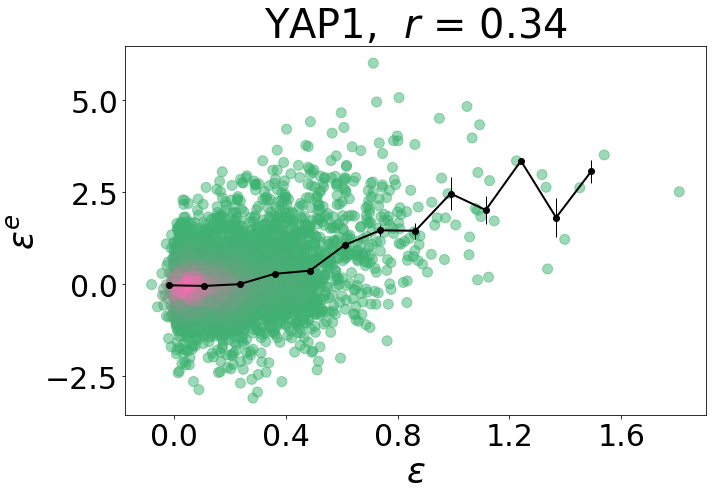

In [7]:
met = 0.5*(m12t+m2t+m21t+m1t)- (m1t+m2t)
# Filter out NaNs
mask = ~np.isnan(met) & ~np.isnan(ee)
x_filtered = met[mask]
y_filtered = ee[mask]

# Bin the data
x1, y1, yerr = regular_bin(x_filtered, y_filtered, nbins=15)

# Extract data
x = x_filtered
y = y_filtered
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Define the color map using pinks and greens
from matplotlib.colors import LinearSegmentedColormap
pink_green_cmap = LinearSegmentedColormap.from_list("pink_green", ["mediumseagreen", "hotpink"])

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(x.values, y.values, c=z, cmap=pink_green_cmap, s=100, alpha=0.5)

# Add binned line
ax.plot(x1, y1, color='black', linewidth=2, label=r'$-a \cdot \log(1 + \exp(-b(x + c)))$')
ax.errorbar(x1, y1, yerr=yerr, fmt='o', color='black', ecolor='black', elinewidth=1, capsize=0)


# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
epi['YAP1'] = corr

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Labels and formatting
ax.set_title(f'YAP1,  $r$ = {corr:.2f}', fontsize=40)
plt.xlabel("$\epsilon$", fontsize=35)
plt.ylabel("$\epsilon^e$", fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
#plt.savefig('ESM2_Figs/YAP1_epistasis2.png', dpi=300)
plt.show()

In [8]:
d = 0.5*(m12t+m2t+m21t+m1t)
# Filter out NaNs
mask = ~np.isnan(d) & ~np.isnan(e12)
x_filtered = d[mask]
y_filtered = e12[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
doubles['YAP1'] = corr

Pearson correlation: 0.4548290766460665
P-value: 0.0


In [9]:
d = m2+m1
# Filter out NaNs
mask = ~np.isnan(d) & ~np.isnan(e12)
x_filtered = d[mask]
y_filtered = e12[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
doubles_add['YAP1'] = corr

Pearson correlation: 0.4880544380504839
P-value: 0.0


In [10]:
me = 0.5*(m12+m2+m21+m1)- (m1+m2)
# Filter out NaNs
mask = ~np.isnan(me) & ~np.isnan(ee)
x_filtered = me[mask]
y_filtered = ee[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
epi_no_transf['YAP1'] = corr

Pearson correlation: 0.17696203292357232
P-value: 6.802853829964431e-50


In [11]:
df = pd.read_csv('Working_Data/650/80_llm_tem1_esm2_650.csv')
df

,Position of First Mut,Ambler Position,WT AA 1,WT AA 2,Mut AA 1,Mut AA 2,Mut 1 Fitness,Mut 1 Fitness Error,Mut 2 Fitness,Mut 2 Fitness Error,...,Epistasis,Upper Level Fractional Error,Lower Level Fractional Error,Positive Sign Epistasis,Negative Sign Epistasis,mut1,mut2,mut21,mut12,double_fitness_llm
0,1,3,M,S,R,C,0.0021,0.0003,0.5702,0.0843,...,NaN,NaN,NaN,NaN,NaN,-11.249504,-6.342741,-6.277232,-10.546577,-17.208027
1,1,3,M,S,I,R,0.4167,0.0459,0.6899,0.0664,...,-1.603535,-1.551035,-1.663265,NaN,NaN,-12.016060,-3.133462,-3.179346,-11.979464,-15.154166
2,1,3,M,S,T,G,0.0631,0.0086,0.4172,0.0377,...,-0.381459,-0.337224,-0.430717,NaN,NaN,-12.137906,-5.534750,-5.502856,-11.175932,-17.175722
3,1,3,M,S,I,G,0.4167,0.0459,0.4172,0.0377,...,-1.182876,-1.135091,-1.236577,NaN,NaN,-12.016060,-5.534750,-5.522659,-11.044299,-17.058884
4,1,3,M,S,I,T,0.4167,0.0459,1.1395,0.1789,...,-0.899889,-0.817011,-1.002403,NaN,NaN,-12.016060,-3.696462,-3.725567,-12.568445,-16.003267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9338,285,289,H,W,I,G,0.0843,0.0125,0.0063,0.0005,...,NaN,NaN,NaN,NaN,NaN,-4.476615,-2.775019,-1.994255,-4.161401,-6.703645
9339,285,289,H,W,A,V,0.6492,0.0675,0.0063,0.0007,...,NaN,NaN,NaN,NaN,NaN,-2.169934,-4.767979,-4.303257,-1.948979,-6.595074
9340,285,289,H,W,R,C,0.9311,0.0831,0.0026,0.0003,...,NaN,NaN,NaN,NaN,NaN,-2.681860,-8.395351,-8.055591,-2.647981,-10.890391
9341,285,289,H,W,P,C,0.0130,0.0011,0.0026,0.0003,...,NaN,NaN,NaN,NaN,NaN,-3.125497,-8.395351,-6.937255,-2.845793,-10.651948


In [12]:
# Compute averaged parameters for two groups
avg_params = {
    "1st": (1, 0.6639, 7.2371),
    "2nd": (1, 0.4298, 4.6874)
}

In [13]:
df.columns

Index(['Position of First Mut', 'Ambler Position', 'WT AA 1', 'WT AA 2',
       'Mut AA 1', 'Mut AA 2', 'Mut 1 Fitness', 'Mut 1 Fitness Error',
       'Mut 2 Fitness', 'Mut 2 Fitness Error', 'Double Mutant Fitness',
       'Double Mutant Fitness Error', 'Epistasis',
       'Upper Level Fractional Error', 'Lower Level Fractional Error',
       'Positive Sign Epistasis', 'Negative Sign Epistasis', 'mut1', 'mut2',
       'mut21', 'mut12', 'double_fitness_llm'],
      dtype='object')

In [14]:
df['log_fitness'] = np.log(df['Double Mutant Fitness'])
df['Mut1_expt_fitness'] = np.log(df['Mut 1 Fitness'])
df['Mut2_expt_fitness'] = np.log(df['Mut 2 Fitness'])


e1 = df['Mut1_expt_fitness']
e2 = df['Mut2_expt_fitness']
e12 = df['log_fitness']
ee = e12-e1-e2 
m1 = df['mut1']
m2 = df['mut2']
m12 = df['mut12']
m21 = df['mut21']

# Apply nonlinear function with '1st' parameters to mut1 and mut2
m1t = transf(m1, *avg_params["1st"])
m2t = transf(m2, *avg_params["1st"])

# Apply nonlinear function with '2nd' parameters to mut12 and mut21
m12t = transf(m12, *avg_params["2nd"])
m21t = transf(m21, *avg_params["2nd"])

Pearson correlation: 0.37471964442024747
P-value: 2.74889222696127e-309


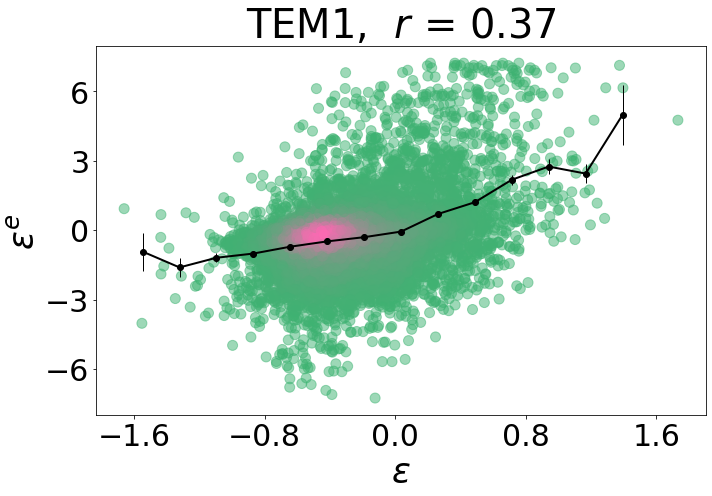

In [15]:
met = 0.5*(m12t+m2t+m21t+m1t)- (m1t+m2t)
# Filter out NaNs
mask = ~np.isnan(met) & ~np.isnan(ee)
x_filtered = met[mask]
y_filtered = ee[mask]

# Bin the data
x1, y1, yerr = regular_bin(x_filtered, y_filtered, nbins=15)

# Extract data
x = x_filtered
y = y_filtered
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Define the color map using pinks and greens
from matplotlib.colors import LinearSegmentedColormap
pink_green_cmap = LinearSegmentedColormap.from_list("pink_green", ["mediumseagreen", "hotpink"])

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(x.values, y.values, c=z, cmap=pink_green_cmap, s=100, alpha=0.5)

# Add binned line
ax.plot(x1, y1, color='black', linewidth=2, label=r'$-a \cdot \log(1 + \exp(-b(x + c)))$')
ax.errorbar(x1, y1, yerr=yerr, fmt='o', color='black', ecolor='black', elinewidth=1, capsize=0)

# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
epi['TEM1'] = corr

ax.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

# Labels and formatting
ax.set_title(f'TEM1,  $r$ = {corr:.2f}', fontsize=40)
plt.xlabel("$\epsilon$", fontsize=35)
plt.ylabel("$\epsilon^e$", fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.tight_layout()
#plt.savefig('ESM2_Figs/TEM1_epistasis2.png',dpi=300)
plt.show()

In [16]:
d = 0.5*(m12t+m2t+m21t+m1t)
# Filter out NaNs
mask = ~np.isnan(d) & ~np.isnan(e12)
x_filtered = d[mask]
y_filtered = e12[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
doubles['TEM1'] = corr

Pearson correlation: 0.6561827808294395
P-value: 0.0


In [17]:
d = m2+m1
# Filter out NaNs
mask = ~np.isnan(d) & ~np.isnan(e12)
x_filtered = d[mask]
y_filtered = e12[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
doubles_add['TEM1'] = corr

Pearson correlation: 0.6308101215405515
P-value: 0.0


In [18]:
me = 0.5*(m12+m2+m21+m1)- (m1+m2)
# Filter out NaNs
mask = ~np.isnan(me) & ~np.isnan(ee)
x_filtered = me[mask]
y_filtered = ee[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
epi_no_transf['TEM1'] = corr

Pearson correlation: 0.09183256318762277
P-value: 5.890954559252543e-19


In [19]:
df = pd.read_csv('Working_Data/650/80_llm_RRM_Domain_esm2_650.csv')
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,first mut,second mut,mut1,mut21,mut2,mut12,exp mut 1,exp mut 2,exp mut double
0,0,7304,7304,G42R,G44E,-5.602533,-11.197366,-11.313063,-5.847799,0.056876,-1.423974,-1.074580
1,1,7305,7305,G42C,G44W,-5.486888,-11.891298,-12.597011,-5.925515,0.049860,-1.302243,-1.496002
2,2,7306,7306,G42S,G44R,-6.795982,-10.888776,-10.802190,-7.221251,0.013671,-1.457364,-1.331191
3,3,7307,7307,G42S,G44W,-6.795982,-12.029054,-12.597011,-7.447011,0.013671,-1.302243,-1.510979
4,4,7308,7308,G42R,G44A,-5.602533,-7.532217,-7.380066,-5.815107,0.056876,0.018809,0.168756
...,...,...,...,...,...,...,...,...,...,...,...,...
29213,29213,36517,36517,K39N,E50D,-3.084569,-3.048594,-3.098360,-3.057889,-0.018550,0.004959,-0.037923
29214,29214,36518,36518,K39N,E49D,-3.084569,-4.890376,-4.882164,-3.084399,-0.018550,-0.039526,-0.051835
29215,29215,36519,36519,K39T,E49D,-4.446651,-4.877553,-4.882164,-4.422321,-0.025583,-0.039526,-0.044487
29216,29216,36520,36520,K39N,F48L,-3.084569,-7.623657,-7.480856,-3.120975,-0.018550,-0.131050,-0.195346


In [20]:
# Compute averaged parameters for two groups
avg_params = {
    "1st": (1, 0.3512, 11.719),
    "2nd": (1, 0.3027, 10.4994)
}

In [21]:
e1 = df['exp mut 1']
e2 = df['exp mut 2']
e12 = df['exp mut double']
ee = e12-e1-e2 
m1 = df['mut1']
m2 = df['mut2']
m12 = df['mut12']
m21 = df['mut21']

# Apply nonlinear function with '1st' parameters to mut1 and mut2
m1t = transf(m1, *avg_params["1st"])
m2t = transf(m2, *avg_params["1st"])

# Apply nonlinear function with '2nd' parameters to mut12 and mut21
m12t = transf(m12, *avg_params["2nd"])
m21t = transf(m21, *avg_params["2nd"])

In [ ]:
met = 0.5*(m12t+m2t+m21t+m1t)- (m1t+m2t)
# Filter out NaNs
mask = ~np.isnan(met) & ~np.isnan(ee)
x_filtered = met[mask]
y_filtered = ee[mask]

# Bin the data
x1, y1,yerr = regular_bin(x_filtered, y_filtered, nbins=15)

# Extract data
x = x_filtered
y = y_filtered
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

# Define the color map using pinks and greens
from matplotlib.colors import LinearSegmentedColormap
pink_green_cmap = LinearSegmentedColormap.from_list("pink_green", ["mediumseagreen", "hotpink"])

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(x.values, y.values, c=z, cmap=pink_green_cmap, s=100, alpha=0.5)

# Add binned line
ax.plot(x1, y1, color='black', linewidth=2, label=r'$-a \cdot \log(1 + \exp(-b(x + c)))$')
ax.errorbar(x1, y1, yerr=yerr, fmt='o', color='black', ecolor='black', elinewidth=1, capsize=0)


# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
epi['RRM'] = corr

ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Labels and formatting
ax.set_title(f'RRM,  $r$ = {corr:.2f}', fontsize=40)
plt.xlabel("$\epsilon$", fontsize=35)
plt.ylabel("$\epsilon^e$", fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.tight_layout()
#plt.savefig('ESM2_Figs/RRM_epistasis2.png', dpi=300)
plt.show()

In [ ]:
d = 0.5*(m12t+m2t+m21t+m1t)
# Filter out NaNs
mask = ~np.isnan(d) & ~np.isnan(e12)
x_filtered = d[mask]
y_filtered = e12[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
doubles['RRM'] = corr

In [ ]:
d = m2+m1
# Filter out NaNs
mask = ~np.isnan(d) & ~np.isnan(e12)
x_filtered = d[mask]
y_filtered = e12[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
doubles_add['RRM'] = corr

In [ ]:
me = 0.5*(m12+m2+m21+m1)- (m1+m2)
# Filter out NaNs
mask = ~np.isnan(me) & ~np.isnan(ee)
x_filtered = me[mask]
y_filtered = ee[mask]
# Compute Pearson correlation
corr, pval = stats.pearsonr(x_filtered, y_filtered)
print("Pearson correlation:", corr)
print("P-value:", pval)
epi_no_transf['RRM'] = corr

In [ ]:
# Protein names
labels = ['TEM1', 'YAP1', 'RRM']
x = np.arange(len(labels))  # label locations
width = 0.35  # width of bars

# Accuracy values
nonadd_values = [epi[protein] for protein in labels]
add_values = [epi_no_transf[protein] for protein in labels]

# Custom colors
colors = ['#FF0000', '#0000FF']  # new custom color hex codes

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, add_values, width, label='Untransformed', color=colors[1])
bars2 = ax.bar(x + width/2, nonadd_values, width, label='Nonlinear Transformed', color=colors[0])

# Labels and formatting
ax.set_ylabel('Pearson Correlation', fontsize=30)
ax.set_title('Epistasis Prediction', fontsize=30)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=20)
ax.set_ylim(0, 0.6)
ax.tick_params(axis='y', labelsize=20)
ax.legend(fontsize=20)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of bars
for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)

plt.tight_layout()

#plt.savefig('ESM2_Figs/Epistasisrb.png',dpi=300)
plt.show()
